In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL
import os
import pathlib

from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-06-09 15:43:14.752076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749483794.929443      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749483794.991573      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Setting the data_dir path
data_dir = pathlib.Path('../input/stanford-dogs-dataset/images/Images')
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

20580

In [3]:
batch_size = 32
img_height, img_width = 180, 180

In [4]:
seed_train_validation = 1
shuffle_value = True
validation_split = 0.3

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = validation_split,
    subset="training",
    seed = seed_train_validation,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed_train_validation,
    image_size=(img_height, img_width),
    batch_size=batch_size
  )

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 20580 files belonging to 120 classes.
Using 14406 files for training.


I0000 00:00:1749483817.643536      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 20580 files belonging to 120 classes.
Using 6174 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

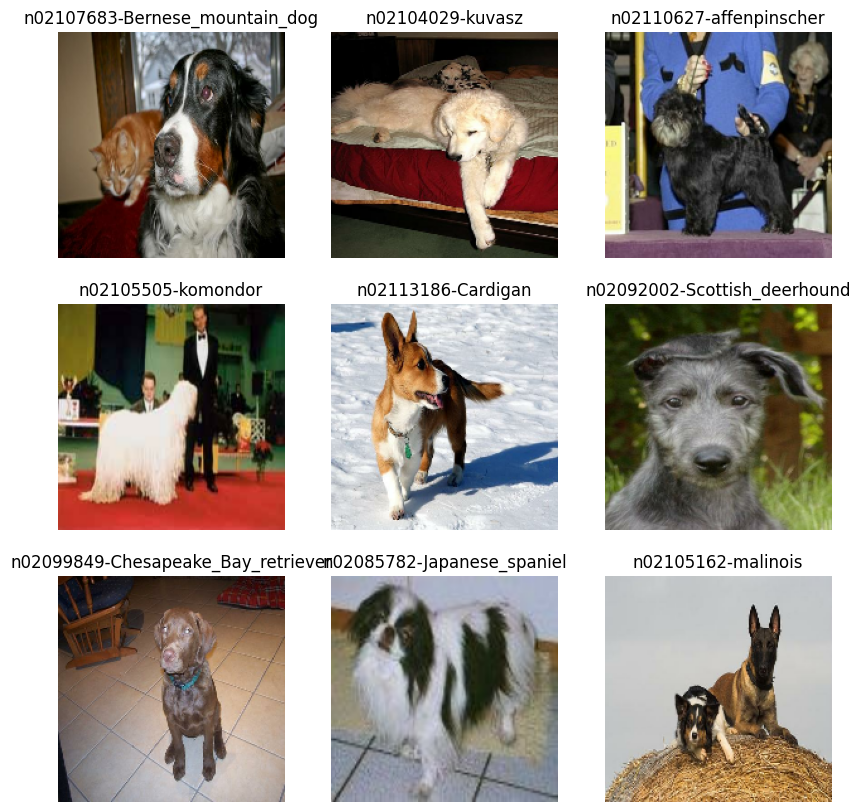

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Loading Data successful

# Prediction

First we start with the baseline prediction

In [7]:
label_counts = Counter()
for _, labels_batch in train_ds:
    label_counts.update(labels_batch.numpy())

most_common_label, count = label_counts.most_common(1)[0]
print(f"Most common label: {most_common_label} ({class_names[most_common_label]}) with count: {count}")

Most common label: 2 (n02085936-Maltese_dog) with count: 179


In [8]:
correct = 0
total = 0

for _, labels in test_ds:
    preds = tf.fill(labels.shape, most_common_label)
    correct += tf.reduce_sum(tf.cast(preds == labels, tf.int32)).numpy()
    total += labels.shape[0]

accuracy = correct / total
print(f"Accuracy of predicting most_common_label: {accuracy:.4f}")

Accuracy of predicting most_common_label: 0.0125


## Making a more sophisticated Model
Next step is working with a more sophisticated model to start actually predicting

In [9]:
normalization_layer = layers.Rescaling(1./255)
resizing_layer = layers.Resizing(180,180)

In [15]:
num_classes = len(class_names)

def initialize_model():
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(180,180,3)), 
        layers.Conv2D(16,3,padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation = 'softmax')
    ])

    model. compile(
        optimizer = 'adam', 
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [16]:
model = initialize_model()

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │          15,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,004,120 (15.27 MB)

 Trainable params: 4,004,120 (15.27 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
epochs = 10 
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    callbacks = [es]
)

Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.0114 - loss: 4.7767 - val_accuracy: 0.0221 - val_loss: 4.5924
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.0286 - loss: 4.5259 - val_accuracy: 0.0476 - val_loss: 4.3325
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.0682 - loss: 4.1762 - val_accuracy: 0.0635 - val_loss: 4.3040
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.1363 - loss: 3.7480 - val_accuracy: 0.0597 - val_loss: 4.6207
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.2532 - loss: 3.1393 - val_accuracy: 0.0544 - val_loss: 5.3437
